In [1]:
! hostname
! whoami
! pwd
# ! nvidia-smi

31-35-58.wireless.csail.mit.edu
akarshkumar0101
/Users/akarshkumar0101/exploration-generalization


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from functools import partial
from einops import rearrange, repeat
import gymnasium as gym
# import gym as gym_old
import gym
from tqdm.auto import tqdm
import cv2
import os
import re
# from ppo import *

import procgen
from procgen import ProcgenEnv

from IPython.display import clear_output

import env_utils
import models
import ppo_rnd
import train
import pretrain
import bc
from pretrain import get_level2files

In [4]:
from env_procgen import make_env
from agent_procgen import Agent, AgentLSTM, IDM

# Collecting Data

In [5]:

# idm = IDM((64, 64, 3), 5)

In [290]:
device = 'mps'

In [291]:
env = make_env('miner', 'ext', 64, 0, 1, 'hard', 0.999, encoder=None, device='cpu', cov=False, actions='ordinal')
obs, info = env.reset()

In [292]:
batch_size = 2048
idm = IDM(env.single_observation_space.shape, env.single_action_space.n, n_features=64, normalize=True, merge='both').to(device)
idm.to(device)
opt = torch.optim.Adam(idm.parameters(), lr=5e-4)#, weight_decay=1e-5)

losses = []

def train(obss, actions, obj='sep'):
    for i_batch in range(24):
        i_step = torch.randint(low=0, high=len(obss)-1, size=(batch_size, ))
        i_env = torch.randint(low=0, high=env.num_envs, size=(batch_size, ))
        obs_now = torch.from_numpy(obss[i_step, i_env]).to(device)
        obs_nxt = torch.from_numpy(obss[i_step+1, i_env]).to(device)
        action_now = torch.from_numpy(actions[i_step, i_env]).to(device)

        v1, v2, logits = idm.forward(obs_now, obs_nxt)
        vlen = (v1-v2).norm(dim=-1)

        ce = torch.nn.functional.cross_entropy(logits, action_now, reduction='none')
        if obj=='sep':
            loss = (1.-vlen).pow(2).mean()
        else:
            loss = ce.mean()
            
        acc = (logits.argmax(dim=-1)==action_now).sum().item()/len(action_now)

        opt.zero_grad()
        loss.backward()
        opt.step()

        pbar.update()
        pbar.set_postfix(loss=str(loss.item()), vlen=str(vlen.mean().item()), acc=acc)
        losses.append(loss.item())


In [293]:
pbar = tqdm(total=24*1000)

for i_iter in range(1000):
    obss, actions = [obs], []
    for t in range(256):
        action = env.action_space.sample()
        obs, rew, done, info = env.step(action)
        obss.append(obs)
        actions.append(action)
    obss = np.stack(obss)
    actions = np.stack(actions)
    
    train(obss, actions, obj='sep' if i_iter<2 else 'what')
    

  0%|          | 0/24000 [00:00<?, ?it/s]

KeyboardInterrupt: 

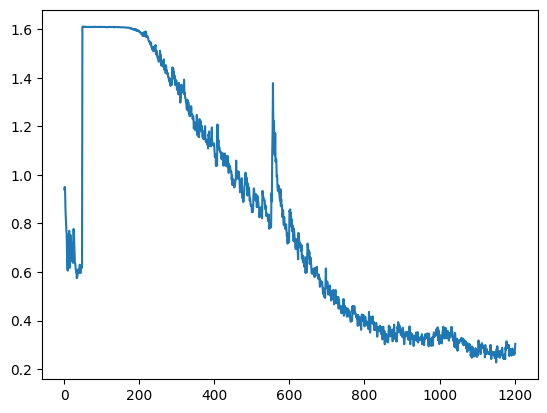

In [294]:
plt.plot(losses)

In [182]:
np.mean(losses[-50:])

0.3206333428621292

In [183]:
obss.shape, actions.shape

((257, 64, 64, 64, 3), (256, 64))

In [85]:
a = actions==2
b = np.abs(obss[1:]-obss[:-1]).max(axis=(-1, -2, -3))==0

In [86]:
a, b

(array([[ True, False, False, ..., False, False, False],
        [False, False, False, ..., False, False,  True],
        [False, False, False, ..., False, False, False],
        ...,
        [False,  True, False, ..., False,  True, False],
        [False,  True, False, ..., False, False, False],
        [False, False, False, ..., False, False,  True]]),
 array([[ True,  True, False, ..., False, False, False],
        [False,  True, False, ..., False, False,  True],
        [False,  True, False, ..., False, False,  True],
        ...,
        [ True,  True, False, ..., False,  True, False],
        [False,  True, False, ...,  True, False, False],
        [False,  True, False, ...,  True, False,  True]]))

In [87]:
env.action_meanings

['left', 'down', 'noop', 'up', 'right']

left


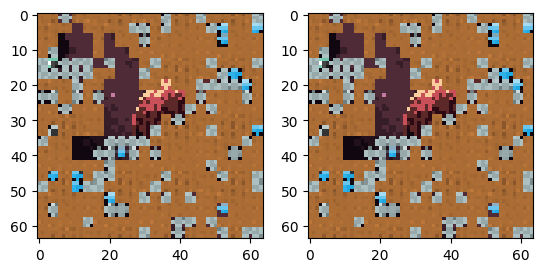

In [88]:
plt.subplot(121); plt.imshow(obss[0,1])
plt.subplot(122); plt.imshow(obss[1,1])
print(env.action_meanings[actions[0, 1]])

In [89]:
a, b = a.flatten(), b.flatten()

In [90]:
a.shape, b.shape

((16384,), (16384,))

In [93]:
print((( a)&( b)).sum()/len(a))
print(((~a)&( b)).sum()/len(a))
print((( a)&(~b)).sum()/len(a))
print(((~a)&(~b)).sum()/len(a))

0.1868896484375
0.12823486328125
0.01458740234375
0.6702880859375


In [97]:
(a&~b).argmax()

33

In [105]:
print(b.sum()/len(a))

0.31512451171875


In [104]:
print(0.1868896484375+0.12823486328125)
print(0.1868896484375/(0.1868896484375+0.12823486328125))
print(0.12823486328125/(0.1868896484375+0.12823486328125))

0.31512451171875
0.5930660468719736
0.4069339531280263


In [111]:
-np.log(0.5930660468719736)*0.1868896484375 -np.log(0.4069339531280263/4)*0.12823486328125

0.3907082006282222

In [307]:
env = make_env('miner', 'ext', 64, 0, 1, 'hard', 0.999, encoder=idm, device=device, cov=True, actions='ordinal')
obs, info = env.reset()

In [308]:
rets_e3b, rets_cov = [], []
rews_e3b, rews_cov = [], []
for t in tqdm(range(256)):
    action = env.action_space.sample()
    obs, rew, done, info = env.step(action)
    rews_e3b.append(info['e3b'].cpu().numpy())
    rews_cov.append(info['cov'].cpu().numpy())
    rets_e3b.extend(env.ret_e3b.tolist())
    rets_cov.extend(env.ret_cov.tolist())
rews_e3b = np.stack(rews_e3b)
rews_cov = np.stack(rews_cov)

  0%|          | 0/256 [00:00<?, ?it/s]

In [ ]:
plt.plot(rews_e3b[:, :].mean(axis=-1), label='e3b')
plt.plot(rews_cov[:, :].mean(axis=-1), label='cov')
plt.legend()
plt.show()

In [281]:
env = make_env('miner', 'ext', 64, 0, 1, 'hard', 0.999, encoder=idm, device=device, cov=True, actions='ordinal')
obs, info = env.reset()

rews_e3b, rews_cov = [[] for _ in range(64)], [[] for _ in range(64)]
mydone = np.zeros(64).astype(bool)
for t in tqdm(range(1024)):
    action = env.action_space.sample()
    obs, rew, done, info = env.step(action)
    mydone = done | mydone
    
    for i_env in range(64):
        if not mydone[i_env]:
            rews_e3b[i_env].append(info['e3b'][i_env].item())
            rews_cov[i_env].append(info['cov'][i_env].item())


  0%|          | 0/1024 [00:00<?, ?it/s]

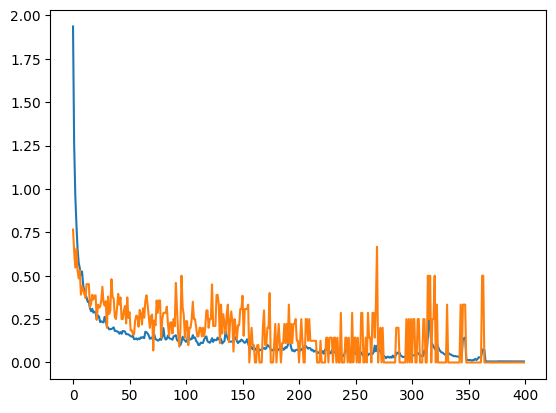

In [285]:
plt.plot([np.mean([rews_e3b[i_env][i] for i_env in range(64) if len(rews_e3b[i_env])>i]) for i in range(400)])
plt.plot([np.mean([rews_cov[i_env][i] for i_env in range(64) if len(rews_cov[i_env])>i]) for i in range(400)])

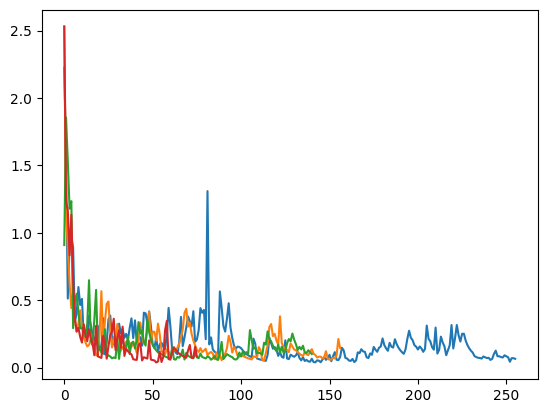

In [277]:
plt.plot(rews_e3b[1])
plt.plot(rews_e3b[2])
plt.plot(rews_e3b[3])
plt.plot(rews_e3b[4])

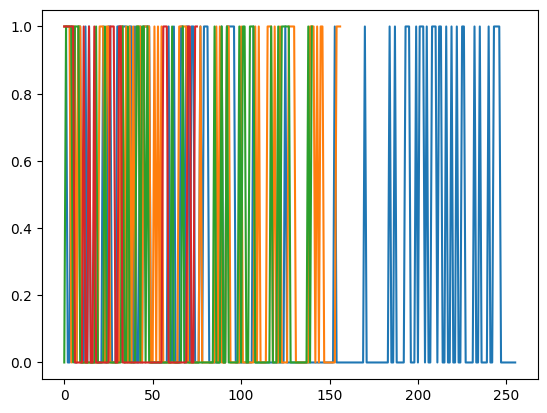

In [278]:
plt.plot(rews_cov[1])
plt.plot(rews_cov[2])
plt.plot(rews_cov[3])
plt.plot(rews_cov[4])

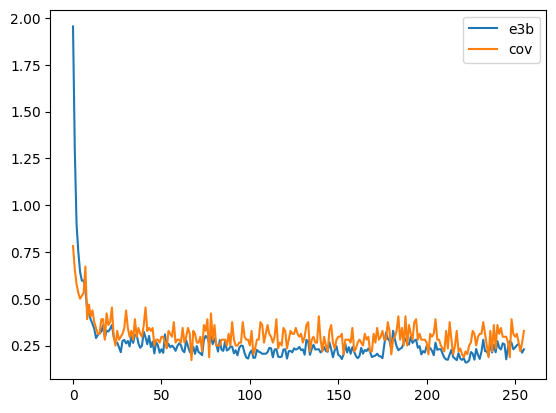

Text(0, 0.5, 'e3b return')

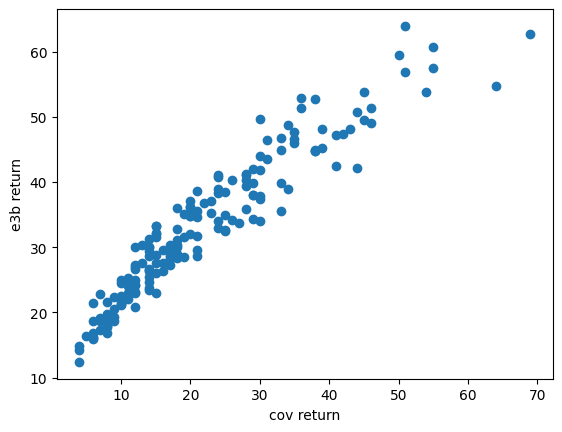

In [327]:
plt.figure()
if True:
plt.scatter(torch.cat(env.rets_cov).tolist(), torch.cat(env.rets_e3b).tolist())
plt.xlabel('cov return'); plt.ylabel('e3b return')

Text(0, 0.5, 'e3b return')

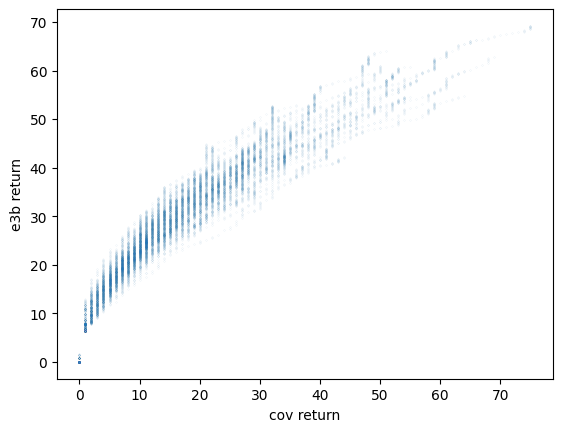

In [309]:
plt.scatter(rets_cov, rets_e3b, s=.001)
plt.xlabel('cov return'); plt.ylabel('e3b return')

In [333]:
a = np.random.randint(0, 5, size=(10000))

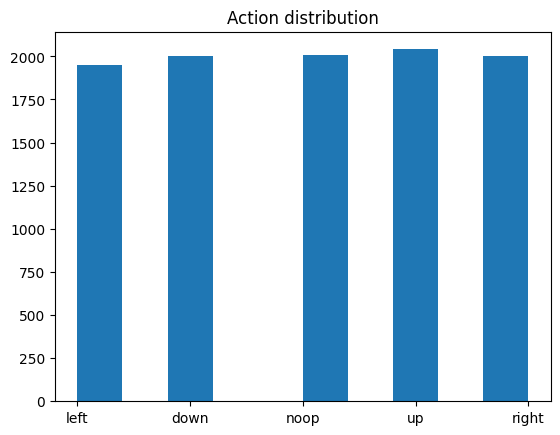

In [345]:
plt.hist(a, bins=env.single_action_space.n*2)
plt.xticks(ticks=np.arange(env.single_action_space.n), labels=env.action_meanings)
plt.title('Action distribution')
plt.show()

Text(0, 0.5, 'e3b return')

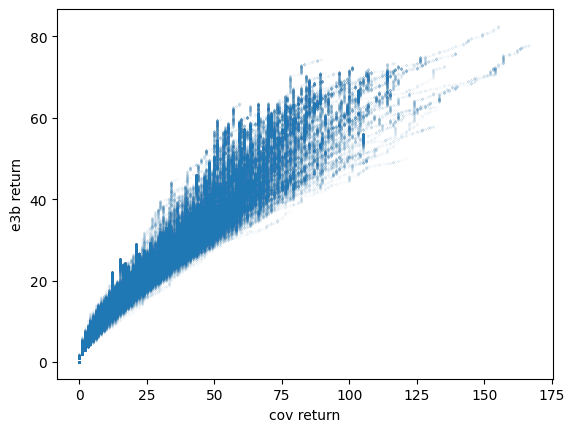

In [234]:
plt.scatter(rets_cov, rets_e3b, s=.001)
plt.xlabel('cov return'); plt.ylabel('e3b return')

Text(0, 0.5, 'e3b return')

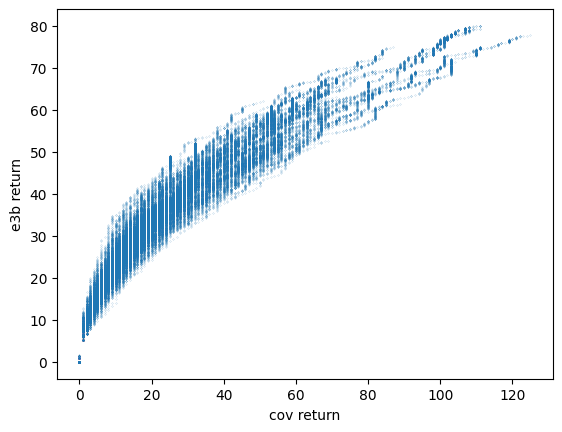

In [151]:
plt.scatter(rets_cov, rets_e3b, s=.01)
plt.xlabel('cov return'); plt.ylabel('e3b return')

In [230]:
env._ret_e3b

AttributeError: attempted to get missing private attribute '_ret_e3b'

In [374]:
device = 'cpu'
env = make_env('miner', 'cov', 64, 0, 0, 'hard', 0.999, encoder=None, device=device, actions='ordinal')
obs, info = env.reset()
obss, actions, rews = [obs], [], []
for i in tqdm(range(10000)):
    action = env.action_space.sample()
    obs, rew, done, info = env.step(action)
    obss.append(obs)
    actions.append(action)
    rews.append(info['cov'].cpu().numpy())
obss = np.stack(obss)
actions = np.stack(actions)
rews = np.stack(rews)
obss.shape, actions.shape

  0%|          | 0/10000 [00:00<?, ?it/s]

((10001, 64, 64, 64, 3), (10000, 64))

In [345]:
actions.shape, rews.shape

((10000, 64), (10000, 64))

In [346]:
for i in range(env.single_action_space.n):
    print(rews.flatten()[(actions==i).flatten()].mean())

0.24157128
0.22353281
0.0018475172
0.23689042
0.24233325


left


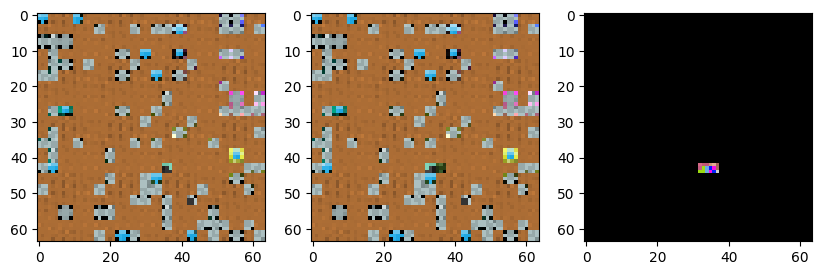

down


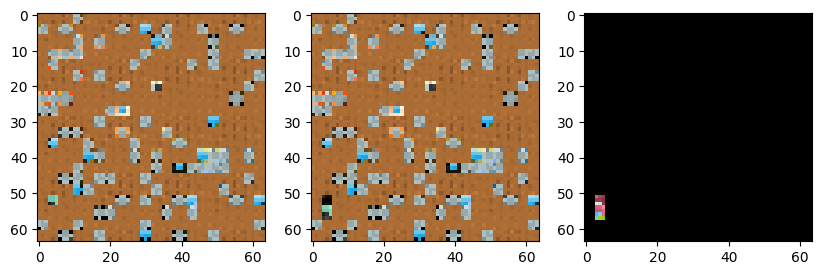

noop


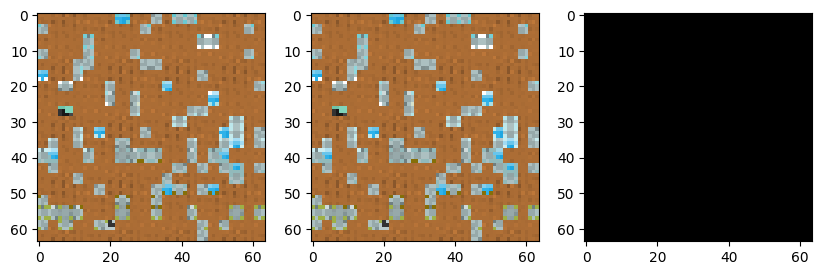

up


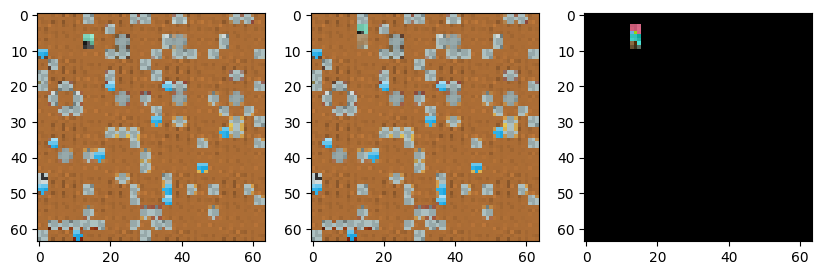

right


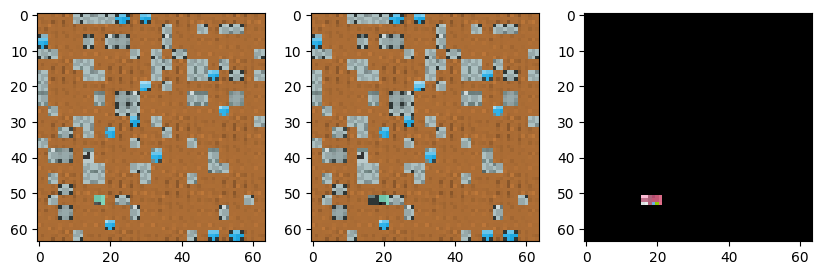

In [347]:
for i in range(env.single_action_space.n):
    a, b = np.where(actions==i)
    i_step, i_env = a[0], b[0]
    print(env.action_meanings[i])
    plt.figure(figsize=(10, 5))
    a, b = obss[i_step  , i_env], obss[i_step+1, i_env]
    plt.subplot(131); plt.imshow(a)
    plt.subplot(132); plt.imshow(b)
    plt.subplot(133); plt.imshow(b-a)
    plt.show()

In [349]:
device = 'mps'
batch_size = 2048
idm = IDM(obs_shape=(64, 64, 3), n_actions=env.single_action_space.n, n_features=100, merge='both')
idm.to(device)
opt = torch.optim.Adam(idm.parameters(), lr=5e-4)#, weight_decay=1e-5)

losses = []

pbar = tqdm(range(5000))
for i_batch in pbar:
    i_step = torch.randint(low=0, high=len(obss)-1, size=(batch_size, ))
    i_env = torch.randint(low=0, high=env.num_envs, size=(batch_size, ))
    obs_now = torch.from_numpy(obss[i_step, i_env]).to(device)
    obs_nxt = torch.from_numpy(obss[i_step+1, i_env]).to(device)
    action_now = torch.from_numpy(actions[i_step, i_env]).to(device)
    
    v1, v2, logits = idm.forward(obs_now, obs_nxt)
    vlen = (v1-v2).norm(dim=-1)
    
    ce = torch.nn.functional.cross_entropy(logits, action_now, reduction='none')
    loss = ce.mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    pbar.set_postfix(loss=str(loss.item()), vlen=str(vlen.mean().item()))
    losses.append(loss.item())


  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

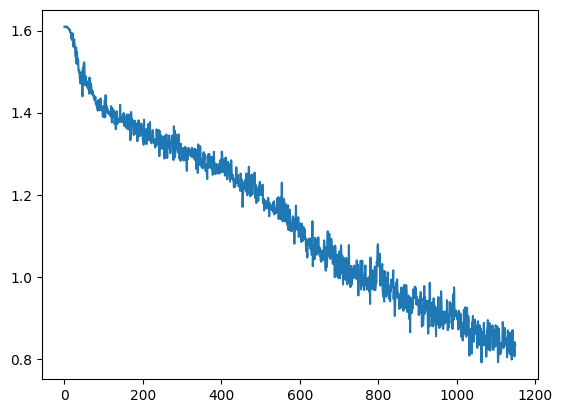

In [350]:
plt.plot(losses)

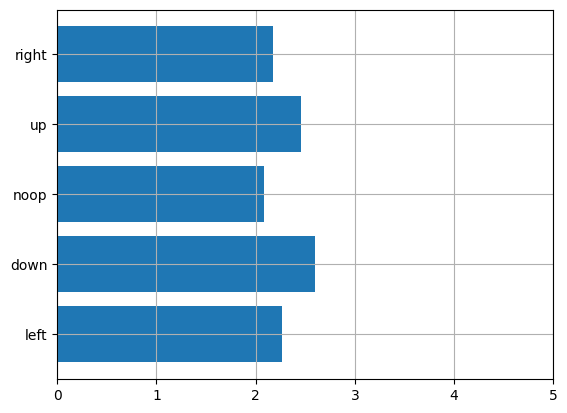

In [361]:
n_actions = env.single_action_space.n
plt.barh(np.arange(n_actions), [np.e**ce[action_now==i].mean().item() for i in range(n_actions)])
plt.yticks(np.arange(n_actions), labels=env.action_meanings)
plt.xlim(0, n_actions)
plt.grid()
plt.show()

In [375]:
wandb.init(project='temp', name=None)

In [376]:
labels = env.action_meanings
values = [np.e**ce[action_now==i].mean().item() for i in range(n_actions)]
values = np.ones(len(values))
data = [[label, val] for (label, val) in zip(labels, values)]
table = wandb.Table(data=data, columns = ["label", "value"])
wandb.log({"my_bar_chart_id" : wandb.plot.bar(table, "label", "value", title="Custom Bar Chart")})

In [379]:
wandb.log({'topic1/headline1/metric': 3.})
wandb.log({'topic1/headline1/metric': 4.})
wandb.log({'topic1/headline1/metric': 2.})
wandb.log({'topic1/headline1/metric': 5.})

In [393]:
env.single_observation_space.shape

(64, 64, 3)

In [429]:
env = make_env('miner', 'ext', 1, 1, 1, 'hard', 0.99, None, device='mps')

In [430]:
env.set_encoder(idm)

In [431]:
obs, info = env.reset()

In [432]:
info['e3b']

tensor([0.], device='mps:0')

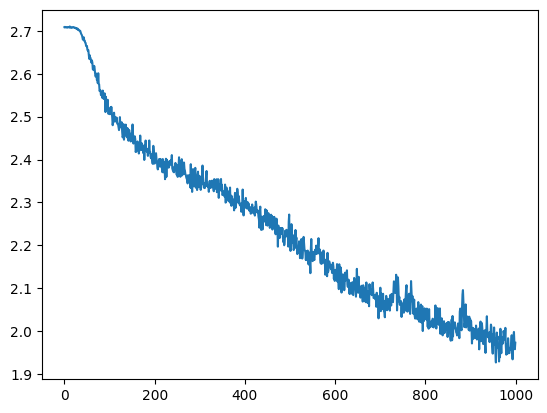

In [106]:
plt.plot(losses)

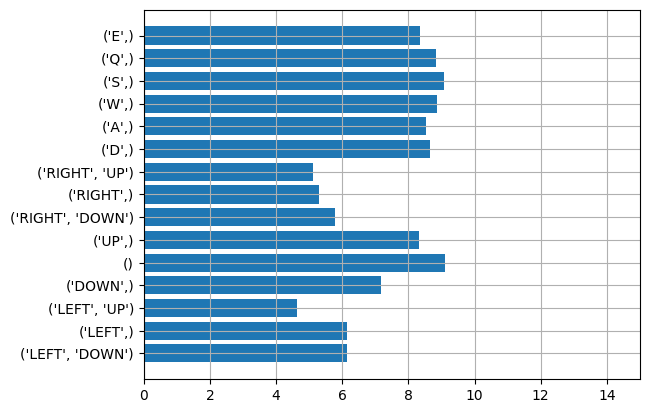

In [105]:
plt.barh(np.arange(15), [np.e**ce[action_now==i].mean().item() for i in range(15)])
plt.yticks(np.arange(15), labels=env.action_meanings)
plt.xlim(0, 15)
plt.grid()
plt.show()

In [118]:
logits.shape, action_now.shape

(torch.Size([2048, 15]), torch.Size([2048]))

In [127]:
(logits.argmax(dim=-1)==action_now).sum().item()/len(action_now)

0.0634765625

In [254]:
from env_procgen import make_env

In [293]:
env = make_env('miner', 'ext', 32, 0, 0, 'easy', 0.999, None, 'cpu', 'all')
print(env.single_action_space, env.action_space, env.action_meanings)
print()
env = make_env('miner', 'ext', 32, 0, 0, 'easy', 0.999, None, 'cpu', 'ordinal')
print(env.single_action_space, env.action_space, env.action_meanings)

Discrete(15) MultiDiscrete([15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15]) ['leftdown', 'left', 'leftup', 'down', 'noop', 'up', 'rightdown', 'right', 'rightup', 'd', 'a', 'w', 's', 'q', 'e']

Discrete(5) MultiDiscrete([5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]) ['left', 'down', 'noop', 'up', 'right']


In [291]:
obs, info = env.reset()
obs, rew, done, info = env.step(env.action_space.sample())

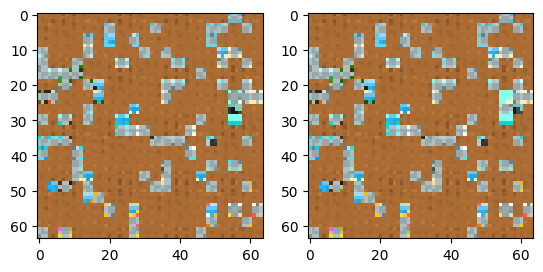

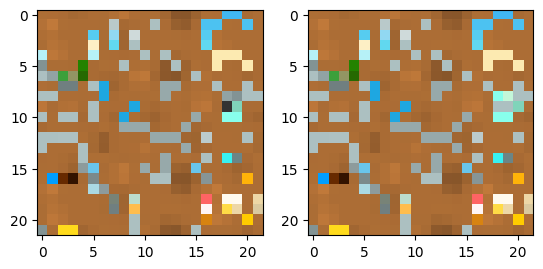

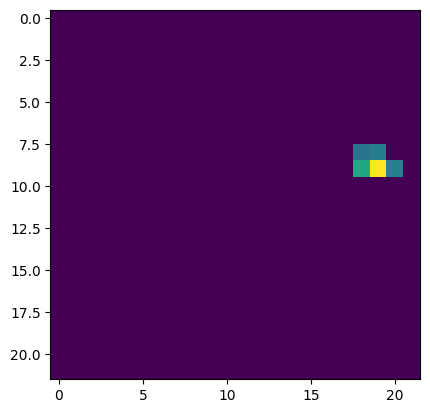

In [226]:
plt.subplot(121)
plt.imshow(obss[1, 2])
plt.subplot(122)
plt.imshow(obss[2, 2])
plt.show()
plt.subplot(121)
plt.imshow(obss[1, 2, ::3, ::3])
plt.subplot(122)
plt.imshow(obss[2, 2, ::3, ::3])
plt.show()
plt.imshow(obss[2, 2, ::3, ::3, 1] - obss[1, 2, ::3, ::3, 1])

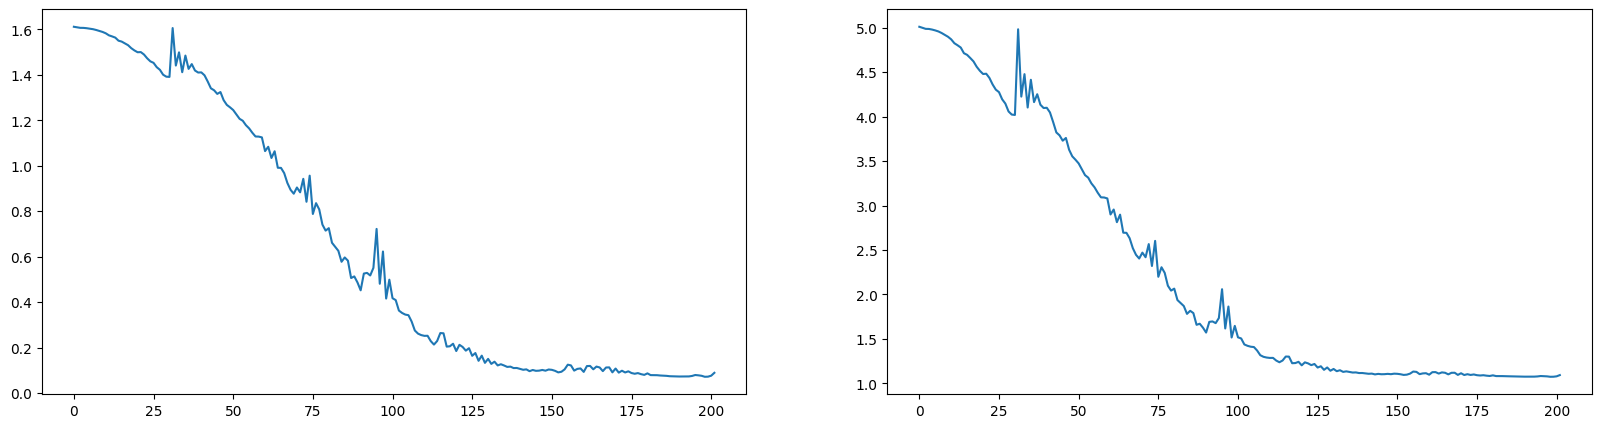

In [277]:
plt.figure(figsize=(20, 5))
plt.subplot(121); plt.plot(np.array(losses))
plt.subplot(122); plt.plot(np.e**np.array(losses))

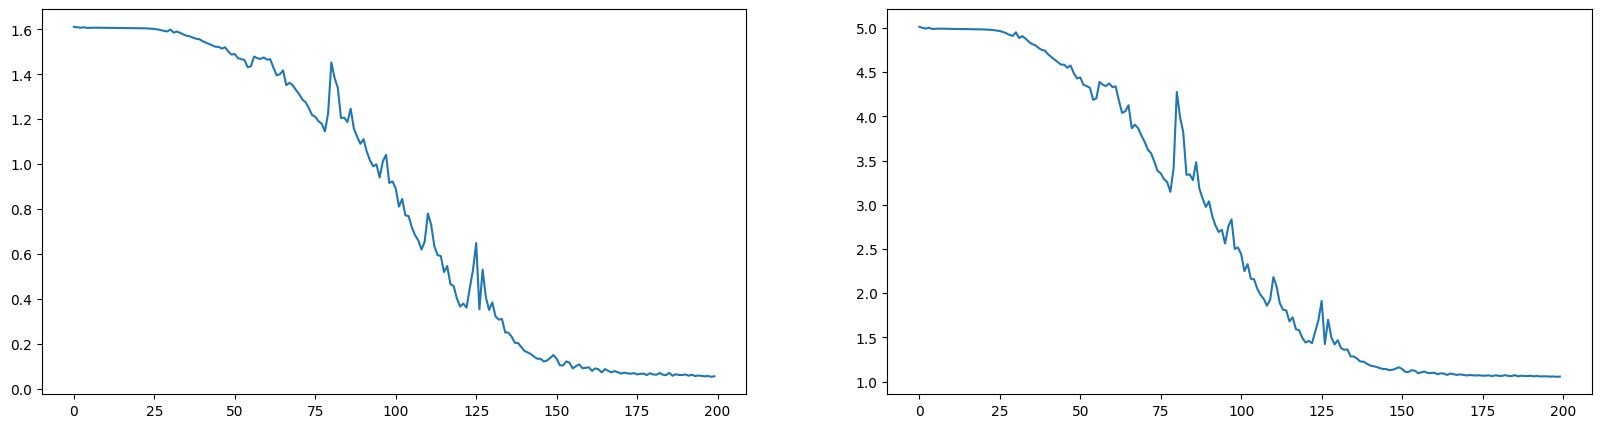

In [267]:
plt.figure(figsize=(20, 5))
plt.subplot(121); plt.plot(np.array(losses))
plt.subplot(122); plt.plot(np.e**np.array(losses))

Action:  0


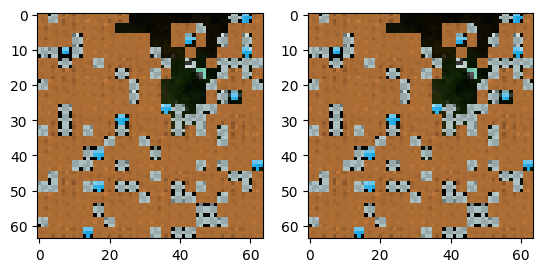

In [233]:
i = 7
plt.subplot(121)
plt.imshow(obs_now[i].cpu().numpy())
plt.subplot(122)
plt.imshow(obs_nxt[i].cpu().numpy())
print('Action: ', action_now[i].item())

(array([43.,  0., 59.,  0.,  0., 40.,  0., 59.,  0., 55.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

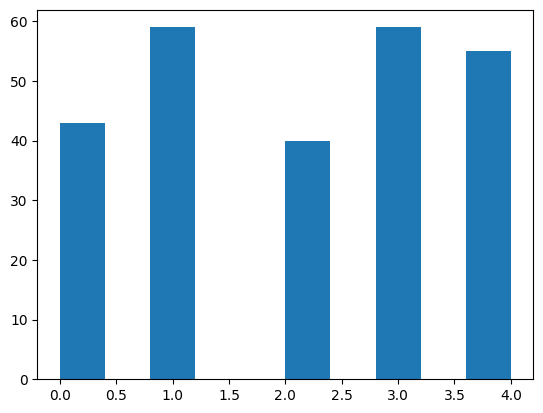

In [ ]:
plt.hist(action_now.cpu().numpy())

In [297]:
from agent_procgen import Agent

In [344]:
device = 'mps'
batch_size = 256

agent = Agent((64, 64, 6), 5)
agent = agent.to(device)
opt = torch.optim.Adam(agent.parameters(), lr=1e-4)#, weight_decay=1e-5)

losses = []

pbar = tqdm(range(10000))
for i_batch in pbar:
    i_step = torch.randint(low=0, high=len(obss)-1, size=(batch_size, ))
    i_env = torch.randint(low=0, high=env.num_envs, size=(batch_size, ))
    obs_now = obss[i_step, i_env]
    obs_nxt = obss[i_step+1, i_env]
    action_now = actions[i_step, i_env]
    obs_now, obs_nxt = torch.from_numpy(obs_now).to(device), torch.from_numpy(obs_nxt).to(device)
    action_now = torch.from_numpy(action_now).to(device)
    _, _, _, _, logits = agent.get_action_and_value(torch.cat([obs_now, obs_nxt], dim=-1), action=action_now)
    
    # if i_batch<20:
    #     loss = (vlen-1.).abs()
    # else:
    ce = torch.nn.functional.cross_entropy(logits, action_now, reduction='none')
    loss = ce.mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    pbar.set_postfix(loss=str(loss.item()))
    losses.append(loss.item())
    # print(torch.tensor([p.std().item() for p in e3b.idm.parameters()]).mean().item())
    # print(e3b.idm.network[0].conv.weight[0,0,0,0].item())
    # print(e3b.idm.network[0].conv.weight.grad[0,0,0,0].item())
    # print()
    

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [345]:
obss.shape

(10001, 64, 64, 64, 3)

In [346]:
10001*64

640064

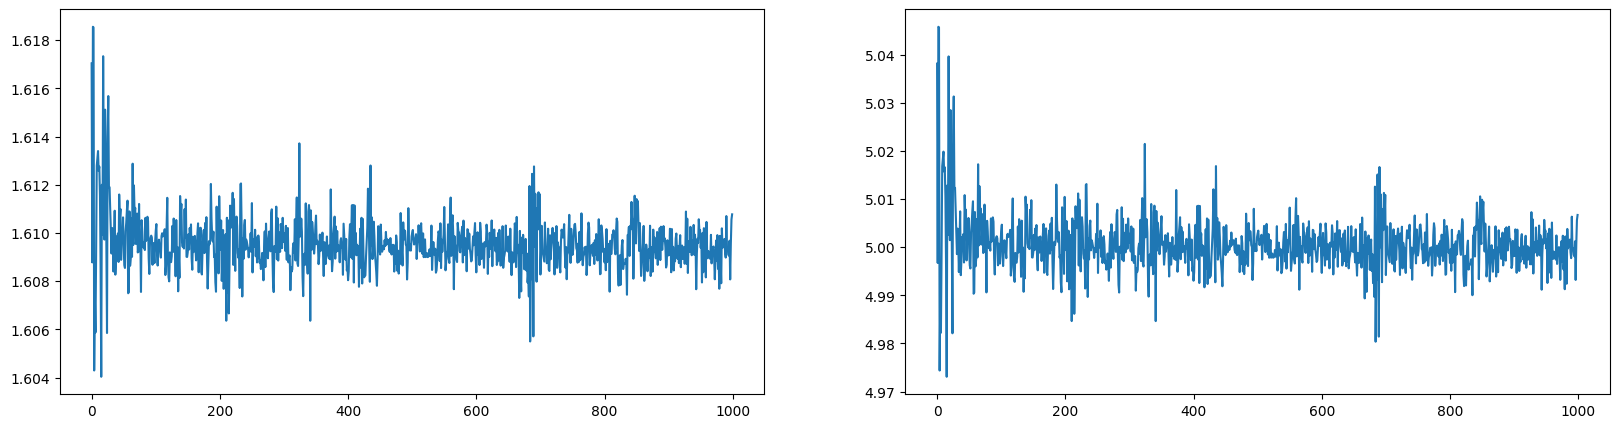

In [337]:
plt.figure(figsize=(20, 5))
plt.subplot(121); plt.plot(np.array(losses))
plt.subplot(122); plt.plot(np.e**np.array(losses))

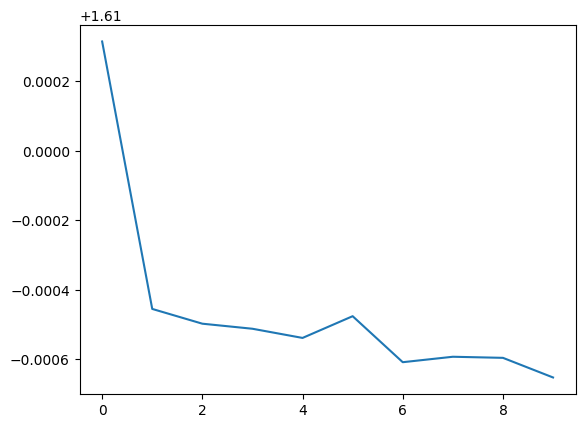

In [343]:
plt.plot(np.array(losses).reshape(10, 100).mean(axis=-1))

In [352]:
np.sum([p.numel() for p in e3b.idm.parameters()])

303505

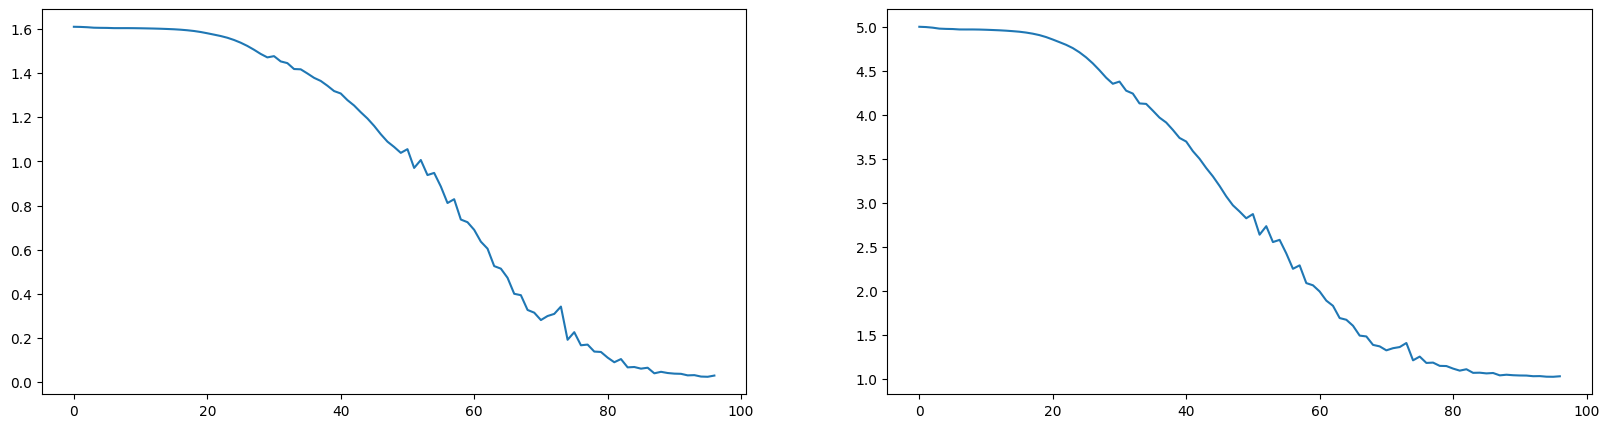

In [308]:
plt.figure(figsize=(20, 5))
plt.subplot(121); plt.plot(np.array(losses))
plt.subplot(122); plt.plot(np.e**np.array(losses))

In [313]:
obs_now.shape, obs_nxt.shape, action_now.shape

(torch.Size([1024, 64, 64, 3]),
 torch.Size([1024, 64, 64, 3]),
 torch.Size([1024]))

right


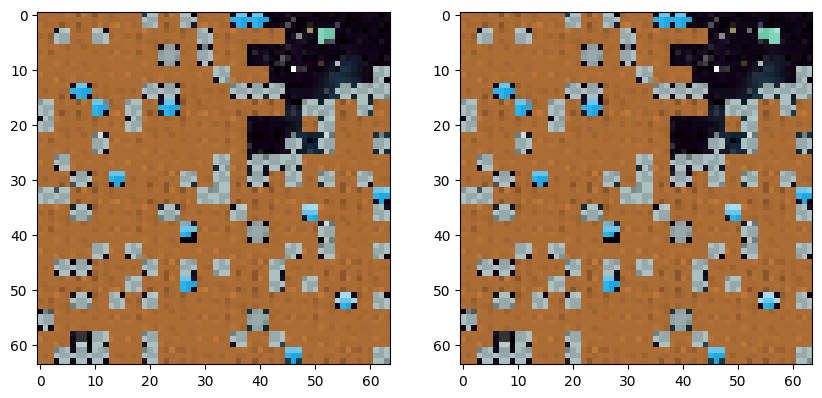

left


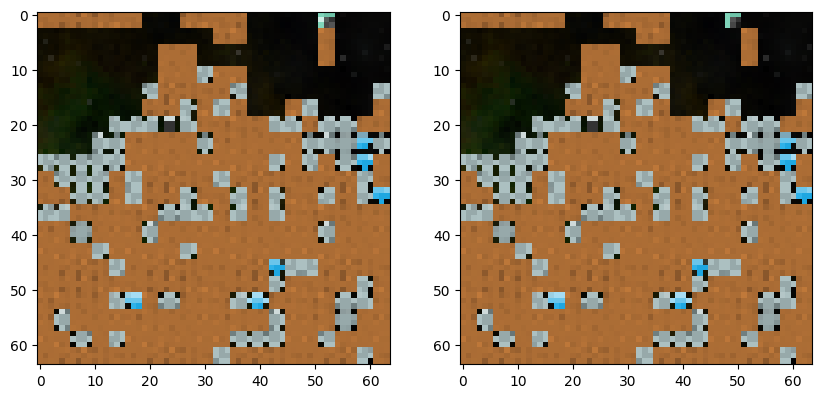

left


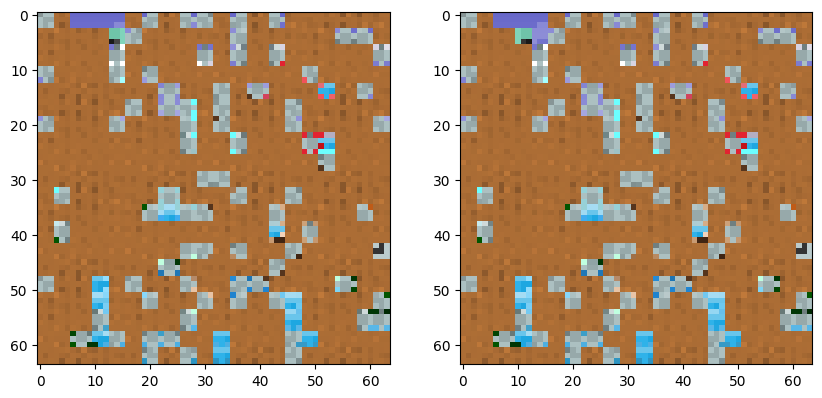

down


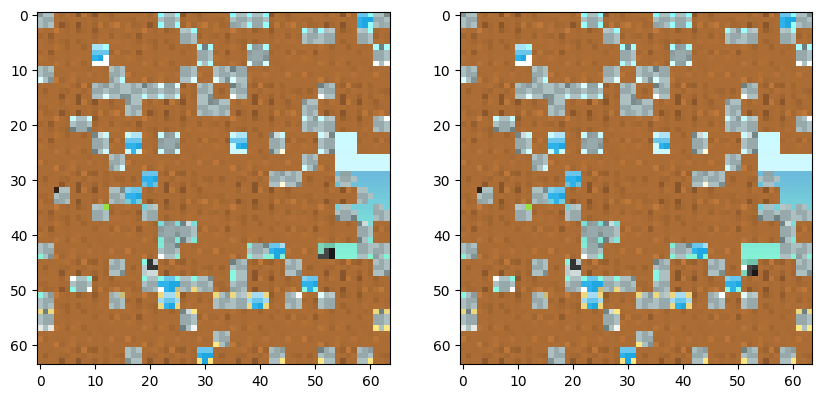

right


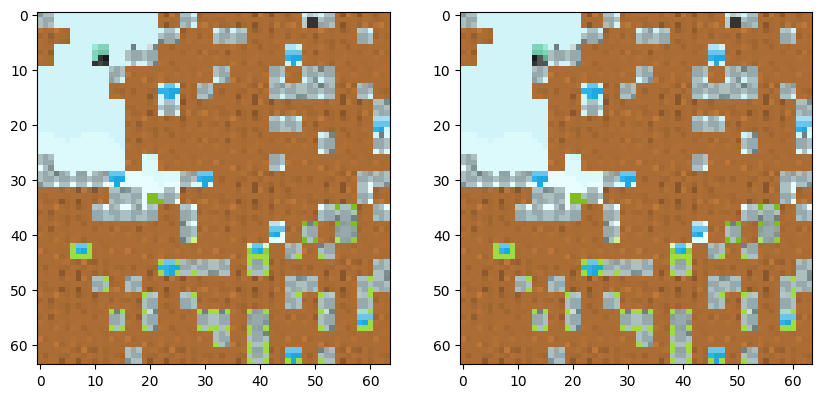

left


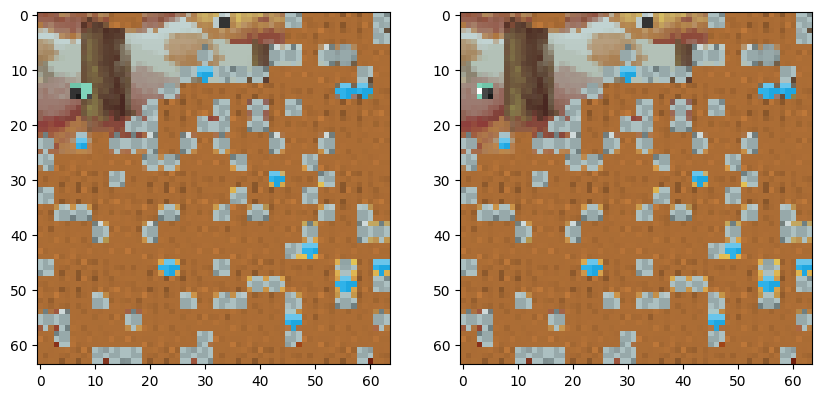

down


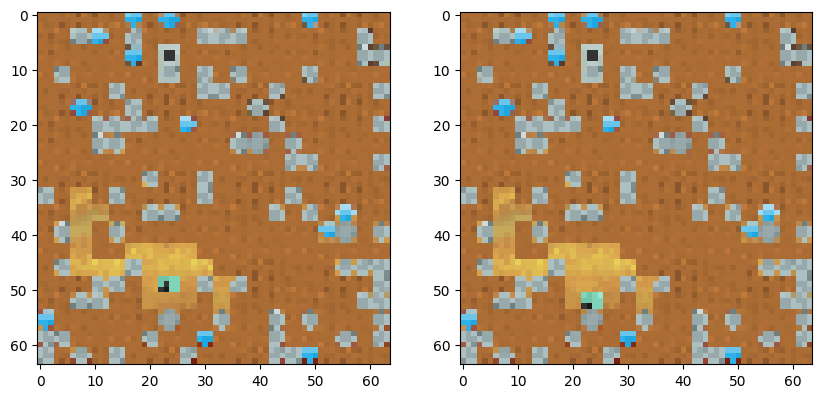

right


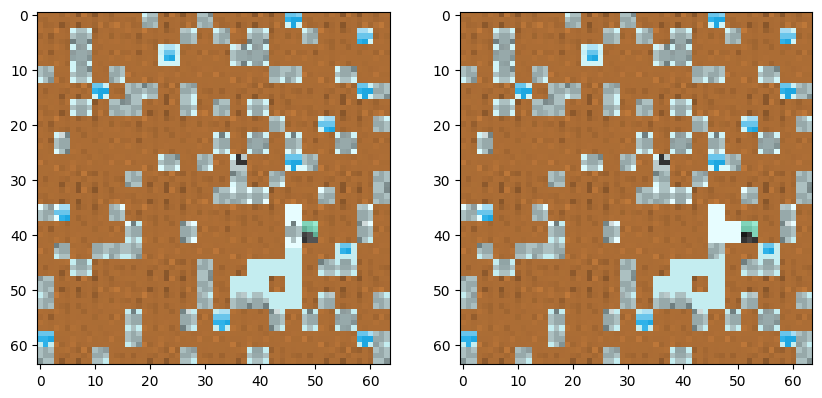

nothing


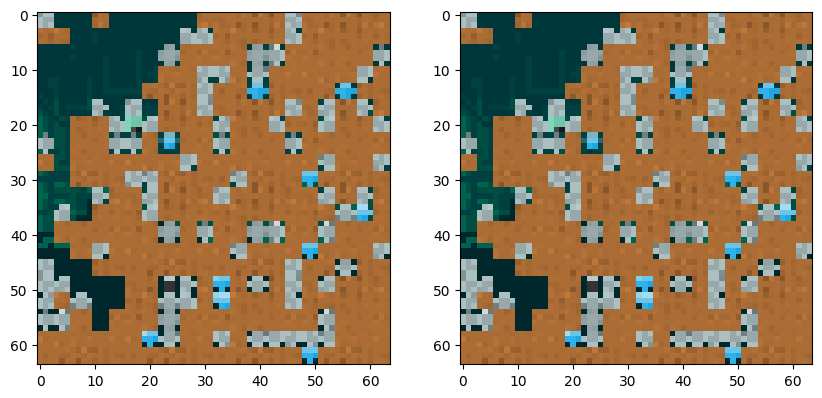

up


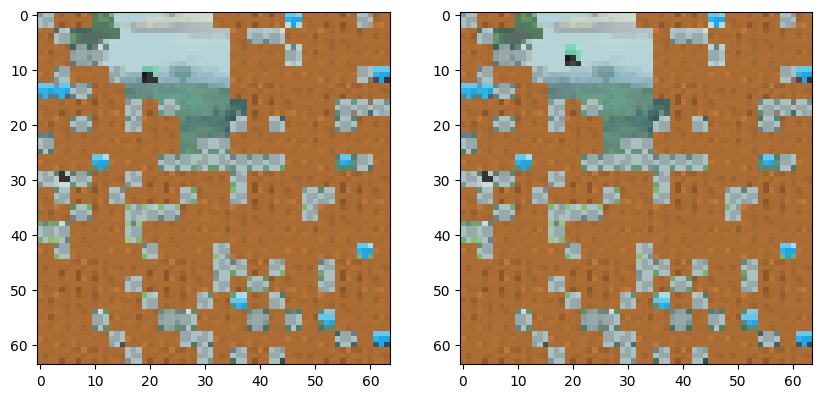

In [11]:
obss.shape

(10001, 64, 64, 64, 3)

In [71]:
from agent_procgen import ResidualBlock
class Net(nn.Module):
    def __init__(self, in_ch=6):
        super().__init__()
        
        self.net = []
        self.conv = nn.Conv2d(in_ch, 64, 3)
        for _ in range(6):
            self.net.append(ResidualBlock(64))
        self.net = nn.Sequential(*self.net)
        self.pool = nn.AdaptiveMaxPool2d([3, 3])
        
        self.net2 = nn.Sequential(
            nn.Linear(64 * 3 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 5),
        )
        
    def forward(self, x):
        x = x.permute((0, 3, 1, 2)) / 255.0  # "bhwc" -> "bchw"
        x = self.conv(x)
        x = self.net(x)
        x = self.pool(x)
        x = x.flatten(1, -1)
        x = self.net2(x)
        return x

net = Net()

net(torch.randn(8, 64, 64, 6));
np.sum([p.numel() for p in net.parameters()])

521157

In [72]:
device = 'mps'
batch_size = 256

net = Net(in_ch=6)
net = net.to(device)
opt = torch.optim.Adam(net.parameters(), lr=1e-2)#, weight_decay=1e-5)

losses = []

pbar = tqdm(range(10000))
for i_batch in pbar:
    opt.zero_grad()
    
    i_step = torch.randint(low=0, high=len(obss)-1, size=(batch_size, ))
    i_env = torch.randint(low=0, high=env.num_envs, size=(batch_size, ))
    obs_now = torch.from_numpy(obss[i_step, i_env]).to(device)
    obs_nxt = torch.from_numpy(obss[i_step+1, i_env]).to(device)
    action_now = torch.from_numpy(actions[i_step, i_env]).to(device)
    logits = net(torch.cat([obs_now, obs_nxt], dim=-1))
    # logits = net(obs_nxt - obs_now)
    
    ce = torch.nn.functional.cross_entropy(logits, action_now, reduction='none')
    loss = ce.mean()
               
    loss.backward()
    opt.step()
    
    pbar.set_postfix(loss=str(loss.item()))
    losses.append(loss.item())


  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [374]:
env = make_env('maze', 'cov', 64, 0, 1, 'hard', 0.999, actions='ordinal')

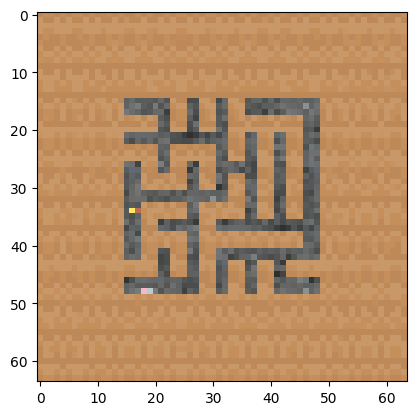

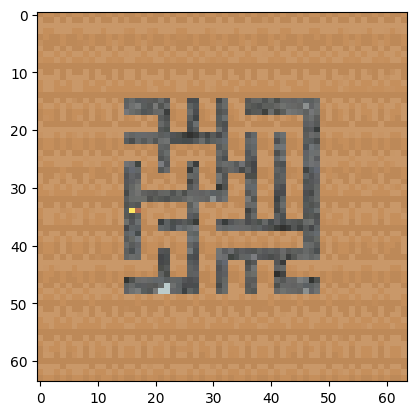

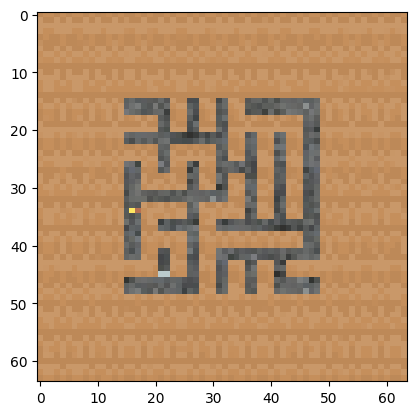

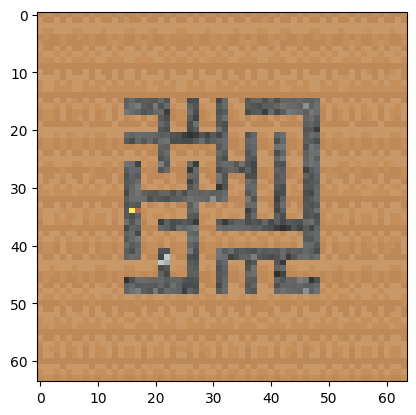

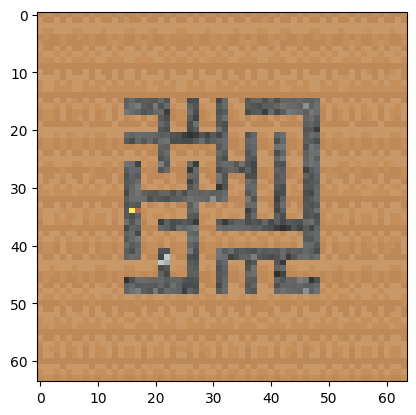

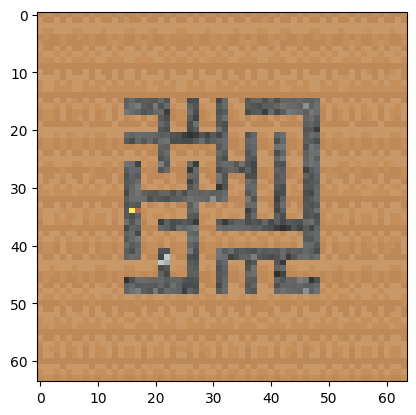

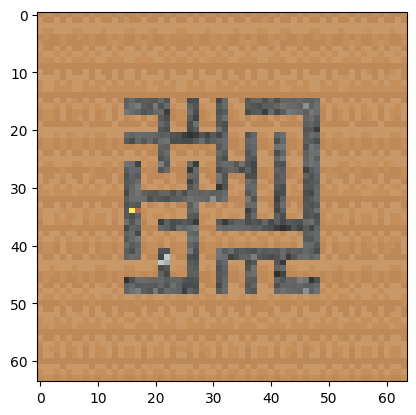

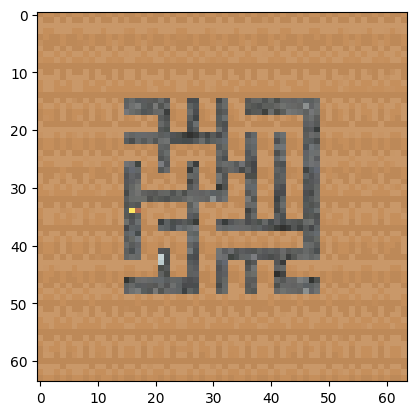

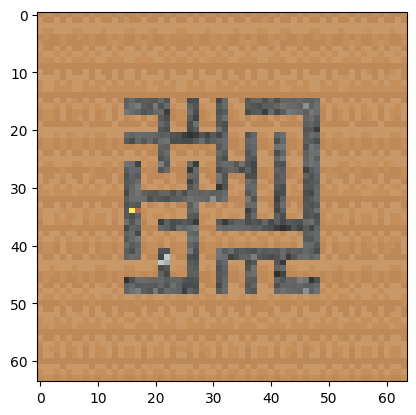

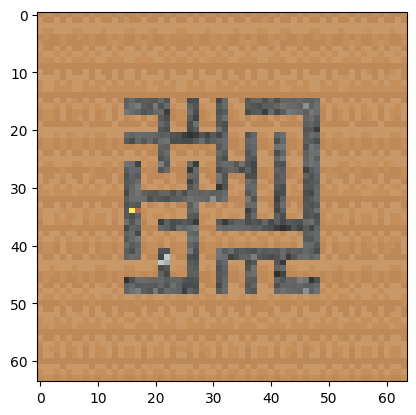

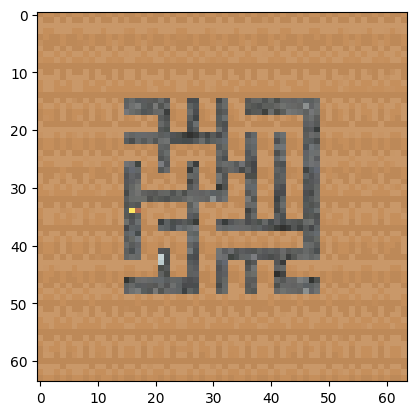

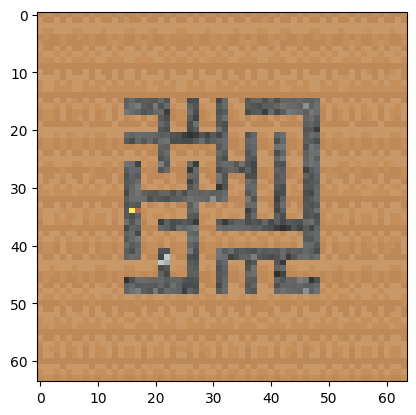

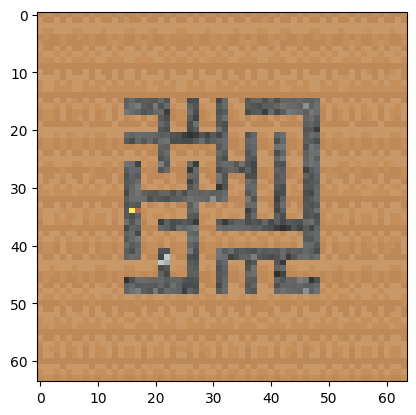

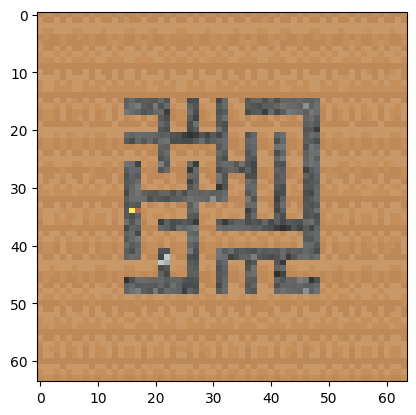

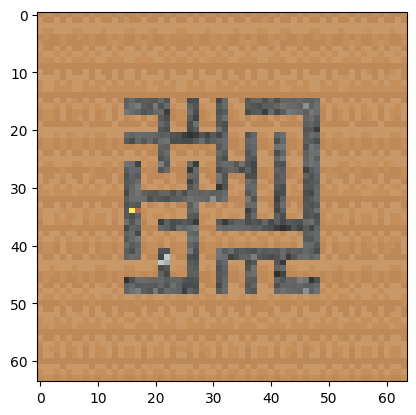

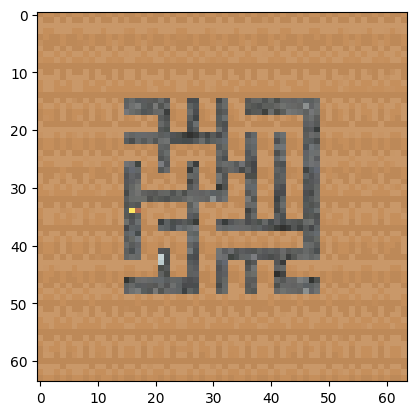

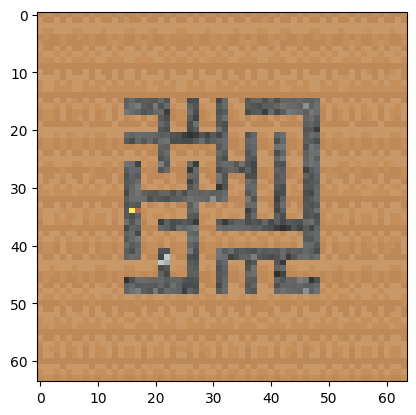

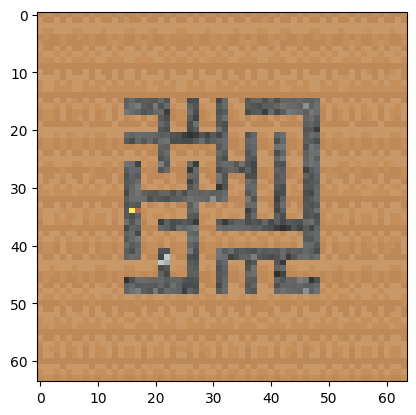

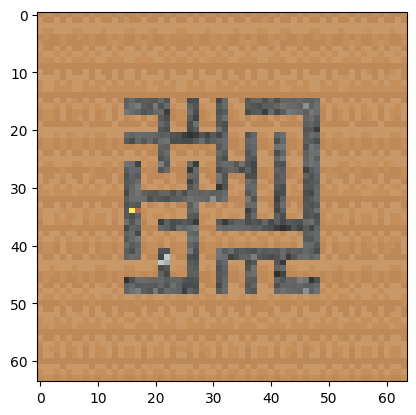

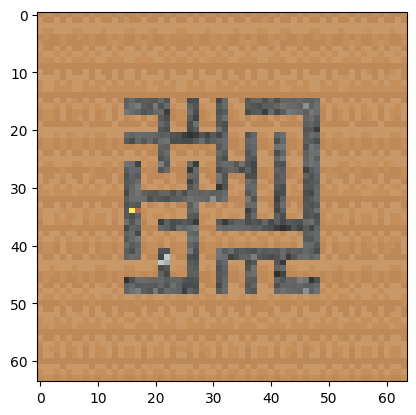

In [373]:
obs, info = env.reset()
for i in range(20):
    obs, rew, done, info = env.step(env.action_space.sample())
    plt.imshow(obs[0])
    plt.show()

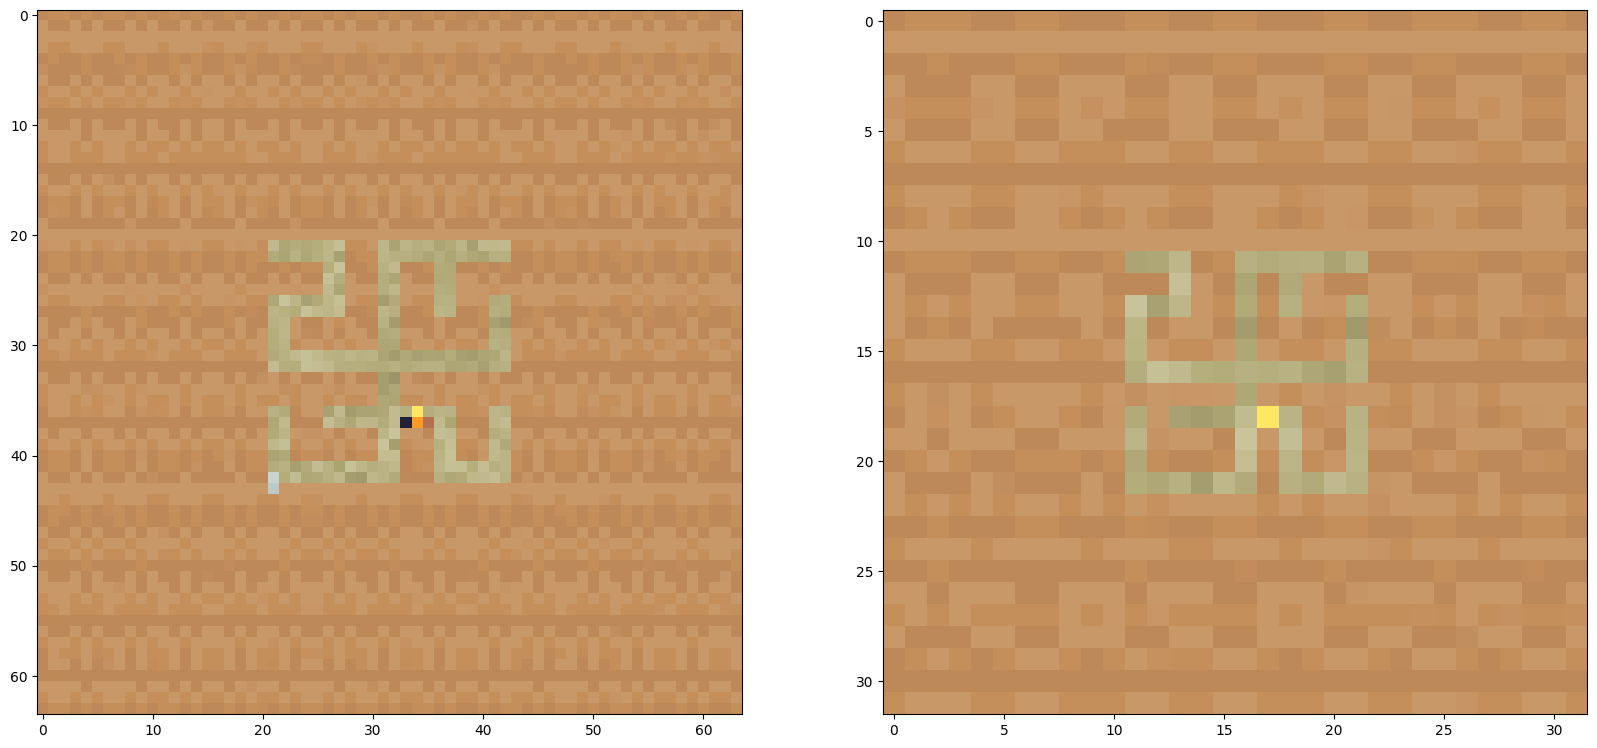

In [368]:
plt.figure(figsize=(20, 20))
plt.subplot(121); plt.imshow(obs[2, ::1, ::1])
plt.subplot(122); plt.imshow(obs[2, ::2, ::2])
plt.show()

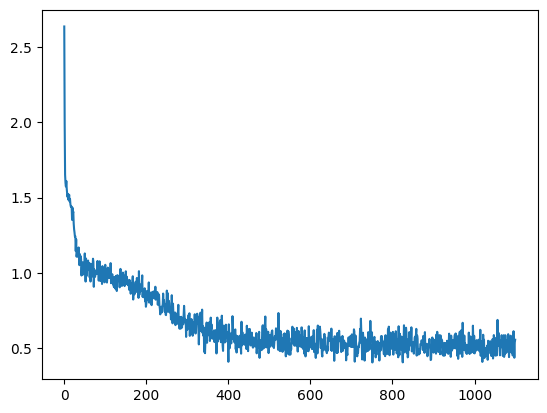

In [49]:
plt.plot(losses)

In [50]:
obss.shape

(10001, 64, 64, 64, 3)

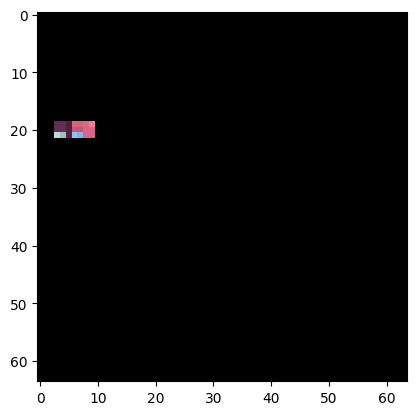

In [57]:
plt.imshow(obss[1, 0]-obss[0, 0])

In [39]:
def multi_batch(ndim):
    def cvt_fn(fn):
        def new_fn(x):
            bs, ds = x.shape[:-ndim], x.shape[-ndim:]
            x = x.reshape(-1, *ds)
            x = fn(x)
            ds = x.shape[1:]
            x = x.reshape(*bs, *ds)
            return x
        return new_fn
    return cvt_fn

def multi_batch(ndims_in, ndims_out):
    def cvt_fn(fn):
        def new_fn(*args):
            args = list(args)
            for i, ndim in enumerate(ndims_in):
                args[i] = args[i].flatten(0, -ndim-1)
            bs, ds = x.shape[:-ndim], x.shape[-ndim:]
            x = x.reshape(-1, *ds)
            x = fn(*args)
            ds = x.shape[1:]
            x = x.reshape(*bs, *ds)
            return x
        return new_fn
    return cvt_fn

In [40]:
# net = nn.Conv2d(3, 3, 3, padding=1)
@multi_batch([2, 1], [1])
def something(x, y):
    print(x.shape, y.shape)
    return x

x = torch.randn(2, 2, 3, 10, 10)
something(x, x).shape

torch.Size([2, 2, 3, 10, 10])
torch.Size([12, 10, 10])

torch.Size([2, 2, 3, 10, 10])
torch.Size([120, 10])



UnboundLocalError: local variable 'x' referenced before assignment

In [342]:
device = 'mps'
batch_size = 256
e3b = E3B(64, obs_shape=(64, 64, 3), n_actions=5, n_features=100, idm_merge='sub', lmbda=0.1)
e3b.to(device)
opt = torch.optim.Adam(e3b.idm.parameters(), lr=5e-4)

losses = []
pbar = tqdm(range(5000))
for i_batch in pbar:
    i_step = torch.randint(low=0, high=len(obss)-1, size=(batch_size, ))
    i_env = torch.randint(low=0, high=env.num_envs, size=(batch_size, ))
    obs_now = torch.from_numpy(obss[i_step, i_env]).to(device)
    obs_nxt = torch.from_numpy(obss[i_step+1, i_env]).to(device)
    action_now = torch.from_numpy(actions[i_step, i_env]).to(device)
    logits = e3b.idm(obs_now, obs_nxt)
    
    with torch.no_grad():
        v1 = e3b.idm.calc_features(obs_now)
        v2 = e3b.idm.calc_features(obs_nxt)
        vlen = (v1-v2).norm(dim=-1).mean()
    
    ce = torch.nn.functional.cross_entropy(logits, action_now, reduction='none')
    loss = ce.mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    pbar.set_postfix(loss=str(loss.item()), vlen=str(vlen.item()))
    losses.append(loss.item())


  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [343]:
obss.shape

(10001, 64, 64, 64, 3)

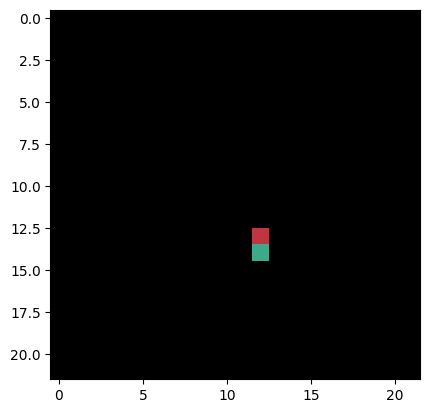

In [359]:
plt.imshow(obss[0, 4, ::3, ::3]-obss[1, 4, ::3, ::3])

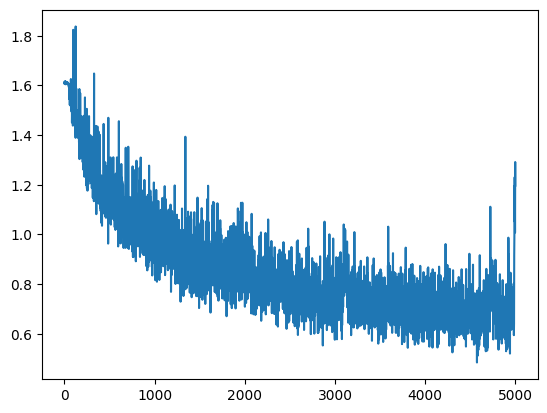

In [90]:
plt.plot(losses)

In [308]:
%%time
env = make_env('miner', 'ext', 64, 0, 0, 'hard', 0.999, e3b=e3b, device=device)
action_strs_miner = ["nothing", "left", "down", "up", "right"]
action_list_miner = np.array([4, 1, 3, 5, 7])

obs, info = env.reset()

for _ in range(100):
    action = np.random.randint(low=0, high=4, size=64)
    obs, rew, done, info = env.step(action_list_miner[action])

CPU times: user 806 ms, sys: 610 ms, total: 1.42 s
Wall time: 1.32 s


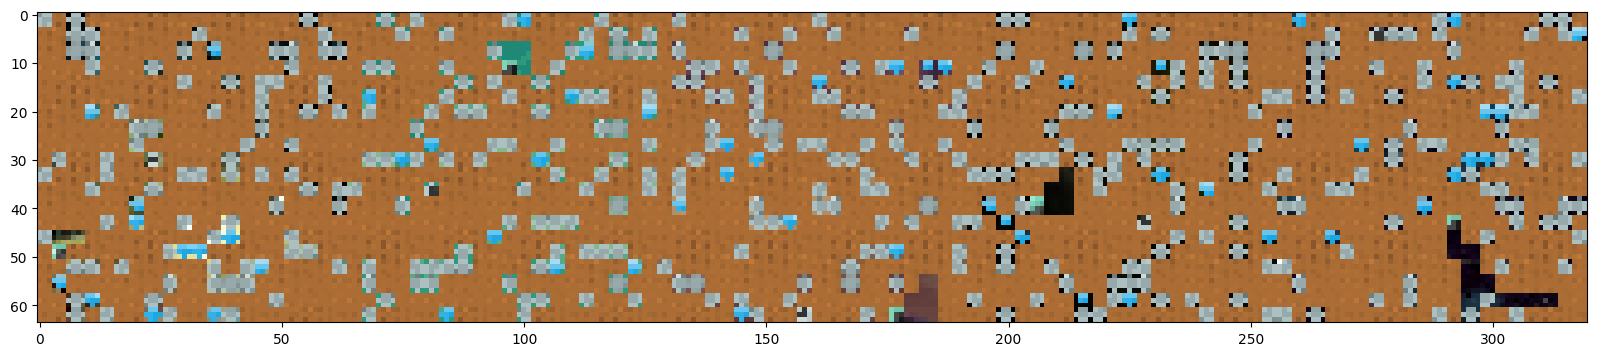

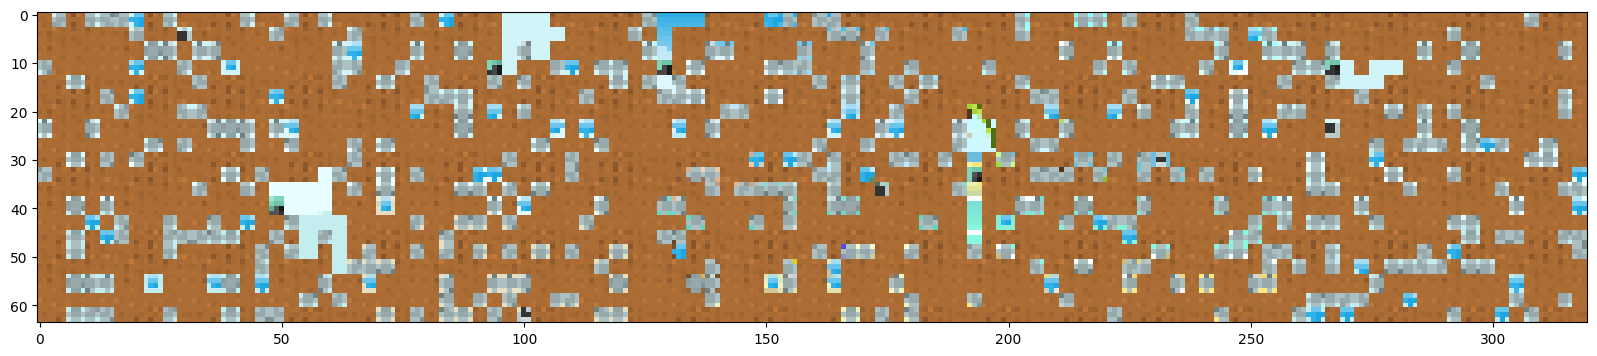

In [337]:
i_env = env.env.env.env._ret_e3b.cpu().argsort()
plt.figure(figsize=(20, 5))
plt.imshow(rearrange(obs[i_env[:5]], 'b h w c -> h (b w) c'))
plt.show()
i_env = env.env.env.env._ret_e3b.cpu().argsort()
plt.figure(figsize=(20, 5))
plt.imshow(rearrange(obs[i_env[-5:]], 'b h w c -> h (b w) c'))
plt.show()

In [244]:
C1, C2 = Cs
v1, v2 = vs
u1, u2 = us
C1.shape, C2.shape, v1.shape, v2.shape, u1.shape, u2.shape

(torch.Size([100, 100]),
 torch.Size([100, 100]),
 torch.Size([100, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))

In [268]:
print((C1-C2).abs().max())
print((v1-v2).abs().max())
print((u1-u2).abs().max())

tensor(9.5367e-07, device='mps:0')
tensor(0., device='mps:0', grad_fn=<MaxBackward1>)
tensor(0.0234, device='mps:0', grad_fn=<MaxBackward1>)


In [273]:
assert torch.allclose(C1, C2)
assert torch.allclose(v1, v2)
assert torch.allclose(C1@v1, u1)
assert torch.allclose(C2@v2, u2)
# assert torch.allclose(C1@v1, C2@v2)

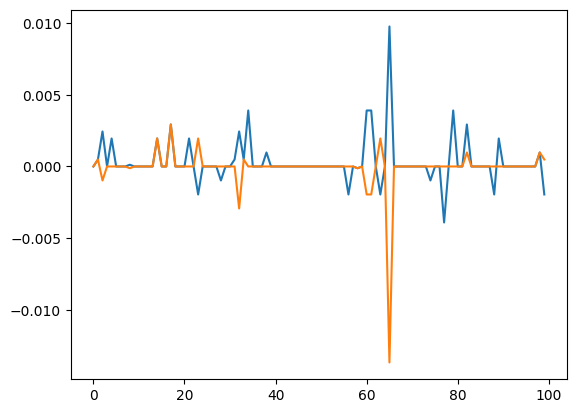

In [274]:
plt.plot(u1[:, 0].detach().cpu().numpy())
plt.plot(u2[:, 0].detach().cpu().numpy())

In [380]:
%%time
env.reset()
for _ in tqdm(range(1000)):
    env.step(np.array([0]*64))

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 5.06 s, sys: 2.63 s, total: 7.69 s
Wall time: 8.45 s


In [381]:
1000*64/8.45

7573.964497041421

In [393]:
@torch.no_grad()
def rollout_agent_test_env(agent, envs, n_steps=1000):
    _, info = envs.reset()
    device = info['obs'].device
    
    next_obs = info['obs']
    next_done = torch.zeros(envs.num_envs).to(device)
    next_lstm_state = (
        torch.zeros(agent.lstm.num_layers, envs.num_envs, agent.lstm.hidden_size).to(device),
        torch.zeros(agent.lstm.num_layers, envs.num_envs, agent.lstm.hidden_size).to(device),
    )  # hidden and cell states (see https://youtu.be/8HyCNIVRbSU)
    for _ in tqdm(range(n_steps)):
        action, _, _, _, next_lstm_state = agent.get_action_and_value(next_obs, next_lstm_state, next_done)
        _, _, _, info = envs.step(action.cpu().numpy())
        next_obs, next_done = info['obs'], info['done'].to(torch.uint8)
    return envs

from agent_procgen import AgentLSTM, E3B

device = 'mps'
agent = AgentLSTM((64, 64, 3), 15).to(device)
e3b = E3B(64, (64, 64, 3), 5, 100, 'sub', 0.1).to(device)

In [394]:
env = make_env('heist', 'ext', 64, 0, 0, 'hard', 0.999, e3b=e3b, device=device)
rollout_agent_test_env(agent, env, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

NotImplementedError: The operator 'aten::remainder.Tensor_out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [ ]:
3000 SPS
0.0003333333333333333


250 SPS
0.004

In [391]:
1/250

0.004

In [392]:
0.004/0.0003333333333333333

12.0

In [56]:
from IPython.display import display


In [80]:
import sympy

I = sympy.matrices.eye(3)
lmbda, v1, v2, v3 = sympy.symbols('\lambda v1 v2 v3')
Cinv = I/lmbda
v = sympy.matrices.Matrix([v1, v2, v3])

for i in range(6):
    display(Cinv)
    display(Cinv.evalf(subs={lmbda: .1, v1: .3, v2: .2, v3: -.6}))
    b = v.T @ Cinv @ v
    u = Cinv@v
    Cinv = Cinv - (u@u.T)/(1+b[0])
    Cinv.simplify()


Matrix([
[1/\lambda,         0,         0],
[        0, 1/\lambda,         0],
[        0,         0, 1/\lambda]])

Matrix([
[10.0,    0,    0],
[   0, 10.0,    0],
[   0,    0, 10.0]])

Matrix([
[(\lambda + v2**2 + v3**2)/(\lambda*(\lambda + v1**2 + v2**2 + v3**2)),                    -v1*v2/(\lambda*(\lambda + v1**2 + v2**2 + v3**2)),                    -v1*v3/(\lambda*(\lambda + v1**2 + v2**2 + v3**2))],
[                   -v1*v2/(\lambda*(\lambda + v1**2 + v2**2 + v3**2)), (\lambda + v1**2 + v3**2)/(\lambda*(\lambda + v1**2 + v2**2 + v3**2)),                    -v2*v3/(\lambda*(\lambda + v1**2 + v2**2 + v3**2))],
[                   -v1*v3/(\lambda*(\lambda + v1**2 + v2**2 + v3**2)),                    -v2*v3/(\lambda*(\lambda + v1**2 + v2**2 + v3**2)), (\lambda + v1**2 + v2**2)/(\lambda*(\lambda + v1**2 + v2**2 + v3**2))]])

Matrix([
[ 8.47457627118644, -1.01694915254237, 3.05084745762712],
[-1.01694915254237,  9.32203389830508, 2.03389830508475],
[ 3.05084745762712,  2.03389830508475, 3.89830508474576]])

Matrix([
[(\lambda + 2*v2**2 + 2*v3**2)/(\lambda*(\lambda + 2*v1**2 + 2*v2**2 + 2*v3**2)),                      2*v1*v2/(\lambda*(-\lambda - 2*v1**2 - 2*v2**2 - 2*v3**2)),                      2*v1*v3/(\lambda*(-\lambda - 2*v1**2 - 2*v2**2 - 2*v3**2))],
[                     2*v1*v2/(\lambda*(-\lambda - 2*v1**2 - 2*v2**2 - 2*v3**2)), (\lambda + 2*v1**2 + 2*v3**2)/(\lambda*(\lambda + 2*v1**2 + 2*v2**2 + 2*v3**2)),                      2*v2*v3/(\lambda*(-\lambda - 2*v1**2 - 2*v2**2 - 2*v3**2))],
[                     2*v1*v3/(\lambda*(-\lambda - 2*v1**2 - 2*v2**2 - 2*v3**2)),                      2*v2*v3/(\lambda*(-\lambda - 2*v1**2 - 2*v2**2 - 2*v3**2)), (\lambda + 2*v1**2 + 2*v2**2)/(\lambda*(\lambda + 2*v1**2 + 2*v2**2 + 2*v3**2))]])

Matrix([
[ 8.33333333333333, -1.11111111111111, 3.33333333333333],
[-1.11111111111111,  9.25925925925926, 2.22222222222222],
[ 3.33333333333333,  2.22222222222222, 3.33333333333333]])

Matrix([
[(\lambda + 3*v2**2 + 3*v3**2)/(\lambda*(\lambda + 3*v1**2 + 3*v2**2 + 3*v3**2)),                      3*v1*v2/(\lambda*(-\lambda - 3*v1**2 - 3*v2**2 - 3*v3**2)),                      3*v1*v3/(\lambda*(-\lambda - 3*v1**2 - 3*v2**2 - 3*v3**2))],
[                     3*v1*v2/(\lambda*(-\lambda - 3*v1**2 - 3*v2**2 - 3*v3**2)), (\lambda + 3*v1**2 + 3*v3**2)/(\lambda*(\lambda + 3*v1**2 + 3*v2**2 + 3*v3**2)),                      3*v2*v3/(\lambda*(-\lambda - 3*v1**2 - 3*v2**2 - 3*v3**2))],
[                     3*v1*v3/(\lambda*(-\lambda - 3*v1**2 - 3*v2**2 - 3*v3**2)),                      3*v2*v3/(\lambda*(-\lambda - 3*v1**2 - 3*v2**2 - 3*v3**2)), (\lambda + 3*v1**2 + 3*v2**2)/(\lambda*(\lambda + 3*v1**2 + 3*v2**2 + 3*v3**2))]])

Matrix([
[ 8.28025477707006, -1.14649681528662, 3.43949044585987],
[-1.14649681528662,  9.23566878980892, 2.29299363057325],
[ 3.43949044585987,  2.29299363057325, 3.12101910828025]])

Matrix([
[(\lambda + 4*v2**2 + 4*v3**2)/(\lambda*(\lambda + 4*v1**2 + 4*v2**2 + 4*v3**2)),                      4*v1*v2/(\lambda*(-\lambda - 4*v1**2 - 4*v2**2 - 4*v3**2)),                      4*v1*v3/(\lambda*(-\lambda - 4*v1**2 - 4*v2**2 - 4*v3**2))],
[                     4*v1*v2/(\lambda*(-\lambda - 4*v1**2 - 4*v2**2 - 4*v3**2)), (\lambda + 4*v1**2 + 4*v3**2)/(\lambda*(\lambda + 4*v1**2 + 4*v2**2 + 4*v3**2)),                      4*v2*v3/(\lambda*(-\lambda - 4*v1**2 - 4*v2**2 - 4*v3**2))],
[                     4*v1*v3/(\lambda*(-\lambda - 4*v1**2 - 4*v2**2 - 4*v3**2)),                      4*v2*v3/(\lambda*(-\lambda - 4*v1**2 - 4*v2**2 - 4*v3**2)), (\lambda + 4*v1**2 + 4*v2**2)/(\lambda*(\lambda + 4*v1**2 + 4*v2**2 + 4*v3**2))]])

Matrix([
[ 8.25242718446602, -1.16504854368932, 3.49514563106796],
[-1.16504854368932,  9.22330097087378, 2.33009708737864],
[ 3.49514563106796,  2.33009708737864, 3.00970873786408]])

Matrix([
[(\lambda + 5*v2**2 + 5*v3**2)/(\lambda*(\lambda + 5*v1**2 + 5*v2**2 + 5*v3**2)),                      5*v1*v2/(\lambda*(-\lambda - 5*v1**2 - 5*v2**2 - 5*v3**2)),                      5*v1*v3/(\lambda*(-\lambda - 5*v1**2 - 5*v2**2 - 5*v3**2))],
[                     5*v1*v2/(\lambda*(-\lambda - 5*v1**2 - 5*v2**2 - 5*v3**2)), (\lambda + 5*v1**2 + 5*v3**2)/(\lambda*(\lambda + 5*v1**2 + 5*v2**2 + 5*v3**2)),                      5*v2*v3/(\lambda*(-\lambda - 5*v1**2 - 5*v2**2 - 5*v3**2))],
[                     5*v1*v3/(\lambda*(-\lambda - 5*v1**2 - 5*v2**2 - 5*v3**2)),                      5*v2*v3/(\lambda*(-\lambda - 5*v1**2 - 5*v2**2 - 5*v3**2)), (\lambda + 5*v1**2 + 5*v2**2)/(\lambda*(\lambda + 5*v1**2 + 5*v2**2 + 5*v3**2))]])

Matrix([
[ 8.23529411764706, -1.17647058823529, 3.52941176470588],
[-1.17647058823529,   9.2156862745098, 2.35294117647059],
[ 3.52941176470588,  2.35294117647059, 2.94117647058824]])

In [70]:
import numpy as np
import torch
from env_procgen import make_env
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm

from agent_procgen import IDM

In [73]:
encoder = IDM((64, 64, 3), 15, 10, merge='sub').to('mps')
for env_id in ['miner', 'heist', 'jumper', 'coinrun', 'fruitbot', 'caveflyer']:
    for distribution_mode in ['easy', 'hard']:
        n_steps, n_envs = 1000, 64
        env = make_env(env_id, 'ext', n_envs, 0, 0, distribution_mode, 0.999, encoder=None, device='cpu')
        start = time.time()
        obs, info = env.reset()
        for t in range(n_steps):
            obs, rew, done, info = env.step(env.action_space.sample())
        sps = n_steps*n_envs/(time.time()-start)
        print(f"{env_id:>15s}, {distribution_mode:>10s}, {sps:12.2f} SPS")
        

          miner,       easy,    129110.38 SPS
          miner,       hard,     74459.98 SPS
          heist,       easy,    143000.53 SPS
          heist,       hard,    123433.47 SPS
         jumper,       easy,     88778.56 SPS
         jumper,       hard,     80813.28 SPS
        coinrun,       easy,    111480.96 SPS
        coinrun,       hard,     98883.53 SPS
       fruitbot,       easy,    120733.98 SPS
       fruitbot,       hard,     84334.58 SPS
      caveflyer,       easy,    122614.03 SPS
      caveflyer,       hard,     90466.26 SPS


In [44]:
from agent_procgen import Agent
agent = Agent((64, 64, 3), 15).to('mps')

In [58]:
n_steps, n_envs = 1000, 64
x = torch.randint(0, 255, (n_envs, 64, 64, 3), dtype=torch.uint8, device='mps')
start = time.time()
for t in range(n_steps):
    with torch.no_grad():
        agent.get_action_and_value(x)
sps = n_steps*n_envs/(time.time()-start)
print(f"{'agent forward':>15s}, {'nolstm':>10s}, {sps:12.2f} SPS")

  agent forward,     nolstm,     10756.99


In [69]:
n_steps, n_envs = 256, 64

x = torch.randint(0, 255, (2048, 64, 64, 3), dtype=torch.uint8, device='mps')
opt = torch.optim.Adam(agent.parameters(), lr=1e-3)

start = time.time()
for i_epoch in range(3):
    for i_batch in range(8):
        _, logprob, _, _, _ = agent.get_action_and_value(x)
        loss = logprob.sum()
        
        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(agent.parameters(), 0.5)
        opt.step()
sps = n_steps*n_envs/(time.time()-start)
print(f"{'agent forward':>15s}, {'nolstm':>10s}, {sps:12.2f} SPS")
        

  agent forward,     nolstm,      5902.28 SPS


In [52]:
obs = np.random.randn(256, 64, 64, 64, 3).astype(np.float32)
obs_mps = torch.zeros(256, 64, 64, 64, 3, device='mps')

In [55]:
%%timeit
for i in range(256):
    x = np.random.randn(64, 64, 64, 3).astype(np.float32)
    obs_mps[i] = torch.from_numpy(x).to('mps')
obs_mps.sum().item()

2.87 s ± 42.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
%%timeit
for i in range(256):
    x = np.random.randn(64, 64, 64, 3).astype(np.float32)
    obs[i] = x
a = torch.from_numpy(obs).to('mps')
a.sum().item()

2.81 s ± 19.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [529]:
# vs = torch.randn(10, 2)
vs = torch.tensor([
    [.1, 0], [1., 0], [2, 0], [3,0], [4,0], [5,0], [6,0], [7,1],
    [5.5, .2], [4,.6],[-1, -2.1],
    [-.9, -2.],
    [-.9, -2.],
    [-.9, -2.],
    [-.9, -2.],
    [10, -3.],
])

In [530]:
Il = torch.eye(2) / 0.1
Cinv = torch.zeros(1, 2, 2)  # b, d, d
Cinv[:] = Il
rews = []
for i, v in enumerate(vs.reshape(len(vs), 1, 2, 1)):
    u = Cinv @ v  # b, d, 1
    b = v.mT @ u  # b, 1, 1
    Cinv = Cinv - u @ u.mT / (1.0 + b)  # b, d, d
    rew_e3b = b[..., 0, 0].detach()
    rews.append(rew_e3b)

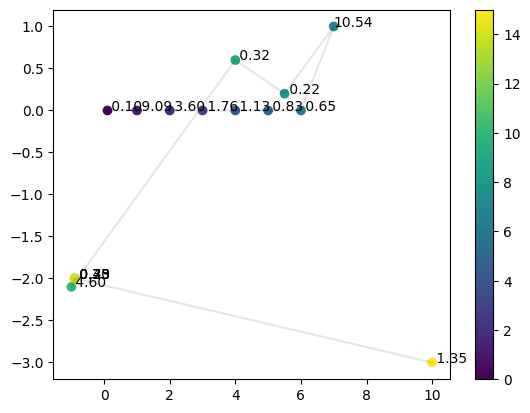

In [531]:
plt.scatter(*vs.numpy().T, c=np.arange(len(vs)))
plt.plot(*vs.numpy().T, c=[0,0,0,.1])
plt.colorbar()
for i in range(len(vs)):
    plt.text(*vs[i].tolist(), f'{rews[i].item():5.2f}')

In [532]:
rews

[tensor([0.1000]),
 tensor([9.0909]),
 tensor([3.6036]),
 tensor([1.7613]),
 tensor([1.1339]),
 tensor([0.8303]),
 tensor([0.6532]),
 tensor([10.5378]),
 tensor([0.2234]),
 tensor([0.3164]),
 tensor([4.6030]),
 tensor([0.7473]),
 tensor([0.4277]),
 tensor([0.2996]),
 tensor([0.2305]),
 tensor([1.3463])]

In [534]:
import agent_procgen

In [535]:
agent = agent_procgen.AgentLSTM((64, 64, 3), 15, 'residual')


In [538]:
for name, p in agent.named_parameters():
    print(name)

network.0.conv.weight
network.0.conv.bias
network.0.res_block0.conv0.weight
network.0.res_block0.conv0.bias
network.0.res_block0.conv1.weight
network.0.res_block0.conv1.bias
network.0.res_block1.conv0.weight
network.0.res_block1.conv0.bias
network.0.res_block1.conv1.weight
network.0.res_block1.conv1.bias
network.1.conv.weight
network.1.conv.bias
network.1.res_block0.conv0.weight
network.1.res_block0.conv0.bias
network.1.res_block0.conv1.weight
network.1.res_block0.conv1.bias
network.1.res_block1.conv0.weight
network.1.res_block1.conv0.bias
network.1.res_block1.conv1.weight
network.1.res_block1.conv1.bias
network.2.conv.weight
network.2.conv.bias
network.2.res_block0.conv0.weight
network.2.res_block0.conv0.bias
network.2.res_block0.conv1.weight
network.2.res_block0.conv1.bias
network.2.res_block1.conv0.weight
network.2.res_block1.conv0.bias
network.2.res_block1.conv1.weight
network.2.res_block1.conv1.bias
network.5.weight
network.5.bias
lstm.weight_ih_l0
lstm.weight_hh_l0
lstm.bias_ih_l